# Домашнее задание № 2

<pre>
ФИО: Никифоров Владимир
</pre>

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import dateutil.relativedelta

import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder

import xgboost

/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
C_RANDOM_STATE=7
np.random.seed(C_RANDOM_STATE)

In [3]:
raw_df = pd.read_csv('../data/rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

PERIOD  cl_id   MCC channel_type  currency        TRDATETIME   amount  \
0  01/10/2017      0  5200          NaN       810  21OCT17:00:00:00   5023.0   
1  01/10/2017      0  6011          NaN       810  12OCT17:12:24:07  20000.0   
2  01/12/2017      0  5921          NaN       810  05DEC17:00:00:00    767.0   
3  01/10/2017      0  5411          NaN       810  21OCT17:00:00:00   2031.0   
4  01/10/2017      0  6012          NaN       810  24OCT17:13:14:24  36562.0   

  trx_category  target_flag  target_sum  
0          POS            0         0.0  
1      DEPOSIT            0         0.0  
2          POS            0         0.0  
3          POS            0         0.0  
4      C2C_OUT            0         0.0

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [5]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [6]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [7]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  391097
Total transactions in test dataset:  99416


### 1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test

### Агрегирование с помощью Pandas и обучение базовой модели

In [8]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [9]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df
    
    

def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    return dataset.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index()

# transaction_by_day_count(raw_df)

In [10]:
raw_df = pd.read_csv('../data/rosbank_train.csv')
raw_df['DATE_'] = raw_df['TRDATETIME'].apply(lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')))

In [11]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  391097
Total transactions in test dataset:  99416


In [12]:
transactions_train.head()

PERIOD  cl_id   MCC channel_type  currency        TRDATETIME   amount  \
0  01/10/2017      0  5200          NaN       810  21OCT17:00:00:00   5023.0   
1  01/10/2017      0  6011          NaN       810  12OCT17:12:24:07  20000.0   
2  01/12/2017      0  5921          NaN       810  05DEC17:00:00:00    767.0   
3  01/10/2017      0  5411          NaN       810  21OCT17:00:00:00   2031.0   
4  01/10/2017      0  6012          NaN       810  24OCT17:13:14:24  36562.0   

  trx_category  target_flag  target_sum               DATE_  
0          POS            0         0.0 2017-10-21 00:00:00  
1      DEPOSIT            0         0.0 2017-10-12 12:24:07  
2          POS            0         0.0 2017-12-05 00:00:00  
3          POS            0         0.0 2017-10-21 00:00:00  
4      C2C_OUT            0         0.0 2017-10-24 13:14:24

In [13]:
transactions_train[transactions_train['target_flag']==1]

PERIOD  cl_id   MCC channel_type  currency        TRDATETIME  \
1366    01/04/2017     23  5411          NaN       810  05APR17:00:00:00   
1367    01/04/2017     23  5411          NaN       810  12APR17:00:00:00   
1368    01/03/2017     23  5541          NaN       810  15MAR17:00:00:00   
1369    01/04/2017     23  5441          NaN       810  05APR17:00:00:00   
1370    01/04/2017     23  6011          NaN       810  20APR17:00:00:00   
1371    01/05/2017     23  5541          NaN       810  08MAY17:00:00:00   
1372    01/05/2017     23  5999          NaN       810  09MAY17:16:22:27   
1373    01/03/2017     23  6011          NaN       810  31MAR17:21:13:09   
1374    01/05/2017     23  5999          NaN       810  22MAY17:19:53:45   
1375    01/04/2017     23  6011          NaN       810  08APR17:14:44:55   
1376    01/04/2017     23  5411          NaN       810  04APR17:00:00:00   
1377    01/03/2017     23  6011          NaN       810  20MAR17:00:00:00   
1378    01/03/2017     23  4829          NaN       810  31MAR17:21:11:20   
1379    01/03/2017     23  5541          NaN       810  21MAR17:00:00:00   
1380    01/03/2017     23  5411          NaN       810  21MAR17:00:00:00   
1381    01/04/2017     23  5411          NaN       810  10APR17:00:00:00   
1382    01/03/2017     23  6012          NaN       810  14MAR17:18:23:30   
1383    01/02/2017     23  6011          NaN       810  17FEB17:17:28:05   
1384    01/04/2017     23  5441          NaN       810  04APR17:00:00:00   
1385    01/04/2017     23  5441          NaN       810  10APR17:00:00:00   
1386    01/03/2017     23  4829          NaN       810  31MAR17:12:48:54   
1387    01/05/2017     23  5541          NaN       810  09MAY17:00:00:00   
1388    01/04/2017     23  5541          NaN       810  06APR17:00:00:00   
1389    01/02/2017     23  6011          NaN       810  17FEB17:18:05:17   
1390    01/03/2017     23  6011          NaN       810  21MAR17:16:11:23   
1391    01/04/2017     23  5411          NaN       810  24APR17:00:00:00   
1392    01/05/2017     23  4829          NaN       810  08MAY17:22:58:10   
1393    01/02/2017     23  5941          NaN       810  26FEB17:00:00:00   
1394    01/03/2017     23  5411          NaN       810  21MAR17:00:00:00   
1395    01/04/2017     23  5441          NaN       810  26APR17:00:00:00   
...            ...    ...   ...          ...       ...               ...   
490437  01/07/2017  10162  5912        type1       810  26JUL17:00:00:00   
490438  01/07/2017  10162  5411        type1       810  02JUL17:00:00:00   
490441  01/08/2017  10162  5941        type1       810  01AUG17:00:00:00   
490466  01/02/2017  10193  6011        type1       810  22FEB17:10:52:03   
490467  01/02/2017  10193  6011        type1       810  11FEB17:14:17:42   
490468  01/12/2016  10193  5712        type1       810  11DEC16:00:00:00   
490469  01/02/2017  10193  6011        type1       810  11FEB17:14:16:47   
490470  01/01/2017  10193  6011        type1       810  19JAN17:13:05:58   
490471  01/01/2017  10193  6011        type1       810  12JAN17:16:09:12   
490485  01/07/2017  10186  6012        type1       810  19JUL17:11:29:38   
490486  01/07/2017  10186  5411        type1       810  20JUL17:00:00:00   
490487  01/07/2017  10186  5977        type1       810  20JUL17:00:00:00   
490488  01/07/2017  10186  5411        type1       810  21JUL17:00:00:00   
490490  01/07/2017  10186  6012        type1       810  06JUL17:00:00:00   
490491  01/07/2017  10186  5411        type1       810  14JUL17:00:00:00   
490492  01/06/2017  10188  4112        type1       810  01JUN17:00:00:00   
490493  01/07/2017  10186  5411        type1       810  18JUL17:00:00:00   
490494  01/08/2017  10186  5499        type1       810  05AUG17:00:00:00   
490496  01/07/2017  10186  7832        type1       810  28JUL17:00:00:00   
490497  01/07/2017  10186  5499        type1       810  25JUL17:00:00:00   
490498  01/06/2017  10188  5541        type1       810  04JU

In [14]:
transactions_train.head()

PERIOD  cl_id   MCC channel_type  currency        TRDATETIME   amount  \
0  01/10/2017      0  5200          NaN       810  21OCT17:00:00:00   5023.0   
1  01/10/2017      0  6011          NaN       810  12OCT17:12:24:07  20000.0   
2  01/12/2017      0  5921          NaN       810  05DEC17:00:00:00    767.0   
3  01/10/2017      0  5411          NaN       810  21OCT17:00:00:00   2031.0   
4  01/10/2017      0  6012          NaN       810  24OCT17:13:14:24  36562.0   

  trx_category  target_flag  target_sum               DATE_  
0          POS            0         0.0 2017-10-21 00:00:00  
1      DEPOSIT            0         0.0 2017-10-12 12:24:07  
2          POS            0         0.0 2017-12-05 00:00:00  
3          POS            0         0.0 2017-10-21 00:00:00  
4      C2C_OUT            0         0.0 2017-10-24 13:14:24

In [15]:
transactions_train[transactions_train['cl_id']==23].groupby(['cl_id','DATE_','MCC','trx_category']).agg(['count'])

PERIOD channel_type currency  \
                                               count        count    count   
cl_id DATE_               MCC  trx_category                                  
23    2017-02-17 17:28:05 6011 DEPOSIT             1            0        1   
      2017-02-17 18:05:17 6011 DEPOSIT             1            0        1   
      2017-02-25 02:16:52 6011 WD_ATM_ROS          1            0        1   
      2017-02-26 00:00:00 5941 POS                 1            0        1   
      2017-03-08 00:00:00 6011 WD_ATM_PARTNER      1            0        1   
      2017-03-09 00:00:00 5722 POS                 1            0        1   
      2017-03-10 00:00:00 5541 POS                 1            0        1   
      2017-03-14 18:23:30 6012 C2C_OUT             1            0        1   
      2017-03-15 00:00:00 5541 POS                 1            0        1   
      2017-03-20 00:00:00 6011 WD_ATM_PARTNER      1            0        1   
      2017-03-21 00:00:00 5411 POS                 2            0        2   
                          5541 POS                 1            0        1   
      2017-03-21 16:11:23 6011 WD_ATM_ROS          1            0        1   
      2017-03-22 00:00:00 5541 POS                 1            0        1   
      2017-03-24 00:00:00 5921 POS                 1            0        1   
      2017-03-25 00:00:00 5541 POS                 1            0        1   
      2017-03-29 12:01:48 6011 WD_ATM_ROS          1            0        1   
      2017-03-31 12:48:54 4829 C2C_IN              1            0        1   
      2017-03-31 13:21:57 6011 WD_ATM_ROS          1            0        1   
      2017-03-31 21:11:20 4829 C2C_IN              1            0        1   
      2017-03-31 21:13:09 6011 WD_ATM_ROS          1            0        1   
      2017-04-03 00:00:00 5411 POS                 1            0        1   
      2017-04-04 00:00:00 5411 POS                 2            0        2   
                          5441 POS                 1            0        1   
      2017-04-05 00:00:00 5411 POS                 1            0        1   
                          5441 POS                 1            0        1   
      2017-04-06 00:00:00 5541 POS                 1            0        1   
      2017-04-08 14:44:55 6011 WD_ATM_ROS          1            0        1   
      2017-04-10 00:00:00 5411 POS                 1            0        1   
                          5441 POS                 1            0        1   
      2017-04-12 00:00:00 5411 POS                 1            0        1   
      2017-04-13 00:00:00 5411 POS                 1            0        1   
      2017-04-20 00:00:00 6011 WD_ATM_PARTNER      1            0        1   
      2017-04-23 00:00:00 5411 POS                 1            0        1   
                          6011 WD_ATM_PARTNER      1            0        1   
      2017-04-24 00:00:00 5411 POS                 1            0        1   
      2017-04-25 00:00:00 5912 POS                 1            0        1   
      2017-04-26 00:00:00 5441 POS                 1            0        1   
      2017-04-27 00:00:00 5411 POS                 1            0        1   
      2017-05-08 00:00:00 5541 POS                 1            0        1   
      2017-05-08 22:58:10 4829 C2C_OUT             1            0        1   
      2017-05-09 00:00:00 5541 POS                 1            0        1   
      2017-05-09 16:22:27 5999 POS                 1            0        1   
      2017-05-10 00:00:00 5541 POS                 1            0        1   
      2017-05-20 00:00:00 6011 WD_ATM_PARTNER      1            0        1   
      2017-05-22 19:53:45 5999 POS                 1            0        1   
      2017-05-25 00:00:00 5411 POS                 1            0        1   
      2017-05-26 00:00:00 5541 POS                 1            0        1   
      2017-05-26 01:07:14 5999 POS                 1            0   

In [16]:
testdf = transactions_train[transactions_train['cl_id']==23].groupby(['cl_id']).fillna(0).reset_index()

In [17]:
print(min(testdf['DATE_']))
print(max(testdf['DATE_']))
print(testdf['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(months=12)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(months=6)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(months=3)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(months=2)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(months=1)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(weeks=2)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(weeks=1)]['DATE_'].count())

2017-02-17 17:28:05
2017-05-26 01:07:14
51
51
51
47
34
11
5
5


In [18]:
transactions_train[transactions_train['target_flag']==1]['trx_category'].value_counts()

POS               216396
WD_ATM_ROS         11119
DEPOSIT             7468
WD_ATM_PARTNER      5553
WD_ATM_OTHER        4954
C2C_IN              3222
C2C_OUT             2984
BACK_TRX            1262
CAT                  680
CASH_ADV              16
Name: trx_category, dtype: int64

In [19]:
type_for_gen = ['POS','WD_ATM_ROS','DEPOSIT','WD_ATM_PARTNER','WD_ATM_OTHER','C2C_IN','C2C_OUT','BACK_TRX']

In [20]:
def create_new_features_df(cl_id_df):
    index=[0]
    columns=['last12m','last6m','last2m','last1m','last2w','last1w']
    ret_df = pd.DataFrame(index=index, columns=columns)
    ret_df['last12m'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=12)]['DATE_'].count()/365
    ret_df['last6m'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=6)]['DATE_'].count()/183
    ret_df['last2m'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=2)]['DATE_'].count()/61
    ret_df['last1m'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=1)]['DATE_'].count()/30
    ret_df['last2w'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(weeks=2)]['DATE_'].count()/14
    ret_df['last2w_delta6m'] = ret_df.apply(lambda x: 0 if (x['last6m']-x['last2w']) == 0 else round(x['last2w']/(x['last6m']-x['last2w']),2), axis=1)
    ret_df['last2w_delta2m'] = ret_df.apply(lambda x: 0 if (x['last2m']-x['last2w']) == 0 else round(x['last2w']/(x['last2m']-x['last2w']),2), axis=1)
    ret_df['last2w_delta1m'] = ret_df.apply(lambda x: 0 if (x['last1m']-x['last2w']) == 0 else round(x['last2w']/(x['last1m']-x['last2w']),2), axis=1)
    ret_df['last1w'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(weeks=1)]['DATE_'].count()/7
    ret_df['last1w_delta6m'] = ret_df.apply(lambda x: 0 if (x['last6m']-x['last1w']) == 0 else round(x['last1w']/(x['last6m']-x['last1w']),2), axis=1)
    ret_df['last1w_delta2m'] = ret_df.apply(lambda x: 0 if (x['last2m']-x['last1w']) == 0 else round(x['last1w']/(x['last2m']-x['last1w']),2), axis=1)
    ret_df['last1w_delta1m'] = ret_df.apply(lambda x: 0 if (x['last1m']-x['last1w']) == 0 else round(x['last1w']/(x['last1m']-x['last1w']),2), axis=1)
    ret_df['last1w_delta2w'] = ret_df.apply(lambda x: 0 if (x['last2w']-x['last1w']) == 0 else round(x['last1w']/(x['last2w']-x['last1w']),2), axis=1)

    for op_type in set(type_for_gen):
        ret_df['last12m'+ op_type] = cl_id_df[(cl_id_df['trx_category'] == op_type) & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=12))]['DATE_'].count()/365
        ret_df['last6m'+ op_type] = cl_id_df[(cl_id_df['trx_category'] == op_type) & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=6))]['DATE_'].count()/183
        ret_df['last2m'+ op_type] = cl_id_df[(cl_id_df['trx_category'] == op_type) & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=2))]['DATE_'].count()/61
        ret_df['last1m'+ op_type] = cl_id_df[(cl_id_df['trx_category'] == op_type) & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=1))]['DATE_'].count()/30
        ret_df['last2w'+ op_type] = cl_id_df[(cl_id_df['trx_category'] == op_type) & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(weeks=2))]['DATE_'].count()/14
        ret_df['last2w'+ op_type+'_delta6m'] = ret_df.apply(lambda x: 0 if (x['last6m'+ op_type]-x['last2w'+ op_type])==0 else round(x['last2w'+ op_type]/(x['last6m'+ op_type]-x['last2w'+ op_type]),2), axis=1)
        ret_df['last2w'+ op_type+'_delta2m'] = ret_df.apply(lambda x: 0 if (x['last2m'+ op_type]-x['last2w'+ op_type])==0 else round(x['last2w'+ op_type]/(x['last2m'+ op_type]-x['last2w'+ op_type]),2), axis=1)
        ret_df['last2w'+ op_type+'_delta1m'] = ret_df.apply(lambda x: 0 if (x['last1m'+ op_type]-x['last2w'+ op_type])==0 else round(x['last2w'+ op_type]/(x['last1m'+ op_type]-x['last2w'+ op_type]),2), axis=1)
        ret_df['last1w'+ op_type] = cl_id_df[(cl_id_df['trx_category'] == op_type) & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(weeks=1))]['DATE_'].count()/7
        ret_df['last1w'+ op_type+'_delta6m'] = ret_df.apply(lambda x: 0 if (x['last6m'+ op_type]-x['last1w'+ op_type])==0 else round(x['last1w'+ op_type]/(x['last6m'+ op_type]-x['last1w'+ op_type]),2), axis=1)
        ret_df['last1w'+ op_type+'_delta2m'] = ret_df.apply(lambda x: 0 if (x['last2m'+ op_type]-x['last1w'+ op_type])==0 else round(x['last1w'+ op_type]/(x['last2m'+ op_type]-x['last1w'+ op_type]),2), axis=1)
        ret_df['last1w'+ op_type+'_delta1m'] = ret_df.apply(lambda x: 0 if (x['last1m'+ op_type]-x['last1w'+ op_type])==0 else round(x['last1w'+ op_type]/(x['last1m'+ op_type]-x['last1w'+ op_type]),2), axis=1)
        ret_df['last1w'+ op_type+'_delta2w'] = ret_df.apply(lambda x: 0 if (x['last2w'+ op_type]-x['last1w'+ op_type])==0 else round(x['last1w'+ op_type]/(x['last2w'+ op_type]-x['last1w'+ op_type]),2), axis=1)
        
    return ret_df
# + отношение количества транзакций на прошлой неделе к количеству транзакций на позапрошлой неделе
# + отношение количества транзакций на прошлой неделе к количеству транзакций на неделе месяц назад
# + отношение количества транзакций на прошлой неделе к количеству транзакций на неделе два месяца назад
# + отношение количества транзакций на прошлой неделе к количеству транзакций на неделе полгода назад
# + валюты - перевод из валют в единую валюту - for future?!
# + выбор правильных категорий - из решения домашки 7 + POS
# + суммы в деньгах нормировать на среднее значение суммы в месяц, например

In [21]:
create_new_features_df(testdf)

last12m    last6m    last2m    last1m    last2w    last1w  last2w_delta6m  \
0  0.139726  0.278689  0.557377  0.366667  0.357143  0.714286           -4.55   

   last2w_delta2m  last2w_delta1m  last1w_delta6m            ...             \
0            1.78            37.5           -1.64            ...              

   last1mWD_ATM_ROS  last2wWD_ATM_ROS  last2wWD_ATM_ROS_delta6m  \
0               0.0               0.0                       0.0   

   last2wWD_ATM_ROS_delta2m  last2wWD_ATM_ROS_delta1m  last1wWD_ATM_ROS  \
0                       0.0                         0               0.0   

   last1wWD_ATM_ROS_delta6m  last1wWD_ATM_ROS_delta2m  \
0                       0.0                       0.0   

   last1wWD_ATM_ROS_delta1m  last1wWD_ATM_ROS_delta2w  
0                         0                         0  

[1 rows x 117 columns]

In [22]:
%%time
train_cl_stat = raw_df.groupby(['cl_id']).apply(create_new_features_df) #transactions_train.groupby(['cl_id']).apply(create_new_features_df)
#train_cl_stat = train_cl_stat.fillna(0).reset_index().drop(['level_1','cl_id'],axis=1)
train_cl_stat = train_cl_stat.reset_index().drop(['level_1'],axis=1).set_index('cl_id')

CPU times: user 19min 2s, sys: 1.08 s, total: 19min 3s
Wall time: 19min 3s


In [23]:
train_cl_stat.head()

last12m    last6m    last2m    last1m    last2w    last1w  \
cl_id                                                               
0      0.013699  0.027322  0.081967  0.033333  0.071429  0.142857   
1      0.284932  0.568306  1.491803  2.000000  1.000000  1.000000   
5      0.389041  0.775956  1.639344  1.466667  2.142857  2.571429   
9      0.106849  0.213115  0.360656  0.533333  0.500000  0.428571   
10     1.268493  2.530055  5.655738  4.500000  3.785714  3.142857   

       last2w_delta6m  last2w_delta2m  last2w_delta1m  last1w_delta6m  \
cl_id                                                                   
0               -1.62            6.78           -1.88           -1.24   
1               -2.32            2.03            1.00           -2.32   
5               -1.57           -4.26           -3.17           -1.43   
9               -1.74           -3.59           15.00           -1.99   
10              -3.01            2.02            5.30           -5.13   

                 ...             last1mWD_ATM_ROS  last2wWD_ATM_ROS  \
cl_id            ...                                                  
0                ...                     0.000000          0.000000   
1                ...                     0.000000          0.000000   
5                ...                     0.033333          0.071429   
9                ...                     0.066667          0.071429   
10               ...                     0.300000          0.142857   

       last2wWD_ATM_ROS_delta6m  last2wWD_ATM_ROS_delta2m  \
cl_id                                                       
0                          0.00                      0.00   
1                          0.00                      0.00   
5                         14.08                      0.57   
9                         -1.62                     -3.21   
10                         2.03                      0.45   

       last2wWD_ATM_ROS_delta1m  last1wWD_ATM_ROS  last1wWD_ATM_ROS_delta6m  \
cl_id                                                                         
0                          0.00               0.0                       0.0   
1                          0.00               0.0                       0.0   
5                         -1.88               0.0                       0.0   
9                        -15.00               0.0                       0.0   
10                         0.91               0.0                       0.0   

       last1wWD_ATM_ROS_delta2m  last1wWD_ATM_ROS_delta1m  \
cl_id                                                       
0                           0.0                       0.0   
1                           0.0                       0.0   
5                           0.0                       0.0   
9                           0.0                       0.0   
10                          0.0                       0.0   

       last1wWD_ATM_ROS_delta2w  
cl_id                            
0                           0.0  
1                           0.0  
5                           0.0  
9                           0.0  
10                          0.0  

[5 rows x 117 columns]

In [24]:
transaction_by_day = transaction_by_day_count(raw_df)
transaction_by_day = transaction_by_day.set_index('cl_id')

transaction_by_hour = transaction_by_hour_count(raw_df)
transaction_by_hour = transaction_by_hour.set_index('cl_id')

In [25]:
def max_date(df):
    agg_df = df.groupby('cl_id')['PERIOD'].max()
    return agg_df

In [26]:
def get_one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [27]:
df_targets = raw_df[['cl_id', 'target_flag']].drop_duplicates().copy()
df_targets.index = df_targets['cl_id']
df_targets = df_targets.drop('cl_id', axis=1)
df_targets.head()

target_flag
cl_id             
0                0
1                0
5                1
9                0
10               0

In [28]:
df_mcc = pd.merge(
    get_aggregated_df(raw_df, agg_type='mean', col_to_groupby='MCC'),
    get_aggregated_df(raw_df, agg_type='sum', col_to_groupby='MCC'),
    left_index=True,
    right_index=True,
)

df_trx_category = pd.merge(
    get_aggregated_df(raw_df, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_df(raw_df, agg_type='sum', col_to_groupby='trx_category'),
    left_index=True,
    right_index=True,
)

df_1 = pd.merge(
    df_mcc,
    df_trx_category,
    left_index=True,
    right_index=True,
)

df_time = pd.merge(
    transaction_by_day,
    transaction_by_hour,
    left_index=True,
    right_index=True,)
    
df = pd.merge(
    df_time,
    df_1,
    left_index=True,
    right_index=True,)

df = pd.merge(
    train_cl_stat,
    df,
    left_index=True,
    right_index=True,)

df = pd.merge(
    pd.DataFrame(max_date(raw_df)),
    df,
    left_index=True,
    right_index=True,)

le = LabelEncoder().fit(df['PERIOD'])
df['PERIOD'] = le.transform(df['PERIOD'])
df = get_one_hot(df, ['PERIOD'])
df = df.drop(['PERIOD'], axis = 1)


df = pd.merge(
    df,
    df_targets,
    left_index=True,
    right_index=True,
    how='inner'
)

In [29]:
df.shape

(5000, 876)

In [30]:
df.head()

last12m    last6m    last2m    last1m    last2w    last1w  \
cl_id                                                               
0      0.013699  0.027322  0.081967  0.033333  0.071429  0.142857   
1      0.284932  0.568306  1.491803  2.000000  1.000000  1.000000   
5      0.389041  0.775956  1.639344  1.466667  2.142857  2.571429   
9      0.106849  0.213115  0.360656  0.533333  0.500000  0.428571   
10     1.268493  2.530055  5.655738  4.500000  3.785714  3.142857   

       last2w_delta6m  last2w_delta2m  last2w_delta1m  last1w_delta6m  \
cl_id                                                                   
0               -1.62            6.78           -1.88           -1.24   
1               -2.32            2.03            1.00           -2.32   
5               -1.57           -4.26           -3.17           -1.43   
9               -1.74           -3.59           15.00           -1.99   
10              -3.01            2.02            5.30           -5.13   

          ...       PERIOD_10  PERIOD_11  PERIOD_12  PERIOD_13  PERIOD_14  \
cl_id     ...                                                               
0         ...               0          0          0          0          0   
1         ...               0          0          0          0          1   
5         ...               0          0          0          0          0   
9         ...               1          0          0          0          0   
10        ...               0          0          1          0          0   

       PERIOD_15  PERIOD_16  PERIOD_17  PERIOD_18  target_flag  
cl_id                                                           
0              0          0          0          1            0  
1              0          0          0          0            0  
5              0          0          0          0            1  
9              0          0          0          0            0  
10             0          0          0          0            0  

[5 rows x 876 columns]

In [31]:
df = df.reset_index().fillna(0)
df.rename(columns={'index':'cl_id'}, inplace=True)
df.head()

cl_id   last12m    last6m    last2m    last1m    last2w    last1w  \
0      0  0.013699  0.027322  0.081967  0.033333  0.071429  0.142857   
1      1  0.284932  0.568306  1.491803  2.000000  1.000000  1.000000   
2      5  0.389041  0.775956  1.639344  1.466667  2.142857  2.571429   
3      9  0.106849  0.213115  0.360656  0.533333  0.500000  0.428571   
4     10  1.268493  2.530055  5.655738  4.500000  3.785714  3.142857   

   last2w_delta6m  last2w_delta2m  last2w_delta1m     ...       PERIOD_10  \
0           -1.62            6.78           -1.88     ...               0   
1           -2.32            2.03            1.00     ...               0   
2           -1.57           -4.26           -3.17     ...               0   
3           -1.74           -3.59           15.00     ...               1   
4           -3.01            2.02            5.30     ...               0   

   PERIOD_11  PERIOD_12  PERIOD_13  PERIOD_14  PERIOD_15  PERIOD_16  \
0          0          0          0          0          0          0   
1          0          0          0          1          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          1          0          0          0          0   

   PERIOD_17  PERIOD_18  target_flag  
0          0          1            0  
1          0          0            0  
2          0          0            1  
3          0          0            0  
4          0          0            0  

[5 rows x 877 columns]

In [32]:
cols_to_type = list(df.columns)

In [33]:
cols_to_type.remove('cl_id')

In [34]:
cols_to_type.remove('target_flag')
df[cols_to_type] = df[cols_to_type].astype(np.float32)

In [35]:
# create transactions dataset for train
transactions_train = df[~df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = df[df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  4000
Total transactions in test dataset:  1000


In [36]:
X_test = transactions_test.drop(['target_flag'], axis=1)
y_test = transactions_test['target_flag']
X_train = transactions_train.drop(['target_flag'], axis=1)
y_train = transactions_train['target_flag']

In [37]:
X_train.head()

cl_id   last12m    last6m    last2m    last1m    last2w    last1w  \
0      0  0.013699  0.027322  0.081967  0.033333  0.071429  0.142857   
1      1  0.284932  0.568306  1.491803  2.000000  1.000000  1.000000   
3      9  0.106849  0.213115  0.360656  0.533333  0.500000  0.428571   
5     11  0.594521  1.185792  2.065574  1.633333  0.357143  0.428571   
7     20  0.210959  0.420765  1.049180  1.366667  2.071429  2.428571   

   last2w_delta6m  last2w_delta2m  last2w_delta1m    ...      PERIOD_9  \
0           -1.62            6.78           -1.88    ...           0.0   
1           -2.32            2.03            1.00    ...           0.0   
3           -1.74           -3.59           15.00    ...           0.0   
5            0.43            0.21            0.28    ...           0.0   
7           -1.25           -2.03           -2.94    ...           0.0   

   PERIOD_10  PERIOD_11  PERIOD_12  PERIOD_13  PERIOD_14  PERIOD_15  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        1.0        0.0   
3        1.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        1.0        0.0        0.0        0.0   
7        0.0        0.0        0.0        0.0        0.0        0.0   

   PERIOD_16  PERIOD_17  PERIOD_18  
0        0.0        0.0        1.0  
1        0.0        0.0        0.0  
3        0.0        0.0        0.0  
5        0.0        0.0        0.0  
7        0.0        0.0        0.0  

[5 rows x 876 columns]

In [38]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

In [39]:
cols.remove('cl_id')

In [40]:
len(cols)

875

In [41]:
X_train[list(X_train.columns[X_train.isnull().sum()>0])].isnull().sum()

Series([], dtype: float64)

In [42]:
X_train.head()

cl_id   last12m    last6m    last2m    last1m    last2w    last1w  \
0      0  0.013699  0.027322  0.081967  0.033333  0.071429  0.142857   
1      1  0.284932  0.568306  1.491803  2.000000  1.000000  1.000000   
3      9  0.106849  0.213115  0.360656  0.533333  0.500000  0.428571   
5     11  0.594521  1.185792  2.065574  1.633333  0.357143  0.428571   
7     20  0.210959  0.420765  1.049180  1.366667  2.071429  2.428571   

   last2w_delta6m  last2w_delta2m  last2w_delta1m    ...      PERIOD_9  \
0           -1.62            6.78           -1.88    ...           0.0   
1           -2.32            2.03            1.00    ...           0.0   
3           -1.74           -3.59           15.00    ...           0.0   
5            0.43            0.21            0.28    ...           0.0   
7           -1.25           -2.03           -2.94    ...           0.0   

   PERIOD_10  PERIOD_11  PERIOD_12  PERIOD_13  PERIOD_14  PERIOD_15  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        1.0        0.0   
3        1.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        1.0        0.0        0.0        0.0   
7        0.0        0.0        0.0        0.0        0.0        0.0   

   PERIOD_16  PERIOD_17  PERIOD_18  
0        0.0        0.0        1.0  
1        0.0        0.0        0.0  
3        0.0        0.0        0.0  
5        0.0        0.0        0.0  
7        0.0        0.0        0.0  

[5 rows x 876 columns]

In [43]:
X_train = X_train[cols].fillna(0)
X_test = X_test[cols].fillna(0)

In [44]:
X_train.iloc[:,20:40].describe().T

count      mean        std          min       25%  \
last2wC2C_OUT_delta1m  4000.0 -0.430063   3.380062   -15.000000  0.000000   
last1wC2C_OUT          4000.0  0.026143   0.088882     0.000000  0.000000   
last1wC2C_OUT_delta6m  4000.0 -0.150317   0.611938   -22.879999  0.000000   
last1wC2C_OUT_delta2m  4000.0 -0.139133   1.843109   -40.669998  0.000000   
last1wC2C_OUT_delta1m  4000.0 -0.186692   2.094626   -15.000000  0.000000   
last1wC2C_OUT_delta2w  4000.0 -0.201137   0.696599    -6.000000  0.000000   
last12mPOS             4000.0  0.227776   0.197234     0.002740  0.060274   
last6mPOS              4000.0  0.454307   0.393391     0.005464  0.120219   
last2mPOS              4000.0  0.939224   0.819668     0.000000  0.245902   
last1mPOS              4000.0  0.953147   0.879751     0.000000  0.200000   
last2wPOS              4000.0  0.951273   0.942380     0.000000  0.142857   
last2wPOS_delta6m      4000.0 -1.815049  14.715239  -183.000000 -1.990000   
last2wPOS_delta2m      4000.0 -1.716459  54.949127 -1037.000000 -3.152500   
last2wPOS_delta1m      4000.0 -1.166067  33.284855  -855.000000 -3.750000   
last1wPOS              4000.0  0.984422   1.005605     0.000000  0.142857   
last1wPOS_delta6m      4000.0 -1.719664  14.355229  -183.000000 -1.850000   
last1wPOS_delta2m      4000.0 -0.355479  31.869038  -610.000000 -2.350000   
last1wPOS_delta1m      4000.0 -0.716080  27.046551  -750.000000 -2.540000   
last1wPOS_delta2w      4000.0 -1.042273   6.815878   -50.000000 -2.920000   
last12mC2C_IN          4000.0  0.003897   0.012046     0.000000  0.000000   

                            50%       75%          max  
last2wC2C_OUT_delta1m  0.000000  0.000000    90.000000  
last1wC2C_OUT          0.000000  0.000000     1.428571  
last1wC2C_OUT_delta6m  0.000000  0.000000     9.150000  
last1wC2C_OUT_delta2m  0.000000  0.000000    30.500000  
last1wC2C_OUT_delta1m  0.000000  0.000000    90.000000  
last1wC2C_OUT_delta2w  0.000000  0.000000     4.000000  
last12mPOS             0.189041  0.345205     1.950685  
last6mPOS              0.377049  0.688525     3.890710  
last2mPOS              0.786885  1.426229     7.950819  
last1mPOS              0.733333  1.466667     8.000000  
last2wPOS              0.714286  1.500000     8.142858  
last2wPOS_delta6m     -1.470000 -1.080000   457.500000  
last2wPOS_delta2m     -1.300000  1.050000  1525.000000  
last2wPOS_delta1m     -1.870000  1.682500   405.000000  
last1wPOS              0.714286  1.571429     8.142858  
last1wPOS_delta6m     -1.350000  0.000000   457.500000  
last1wPOS_delta2m     -1.130000  0.710000   671.000000  
last1wPOS_delta1m     -0.650000  0.910000   300.000000  
last1wPOS_delta2w      0.000000  0.670000    56.000000  
last12mC2C_IN          0.000000  0.002740     0.284932

In [52]:
cols

['last12m',
 'last6m',
 'last2m',
 'last1m',
 'last2w',
 'last1w',
 'last2w_delta6m',
 'last2w_delta2m',
 'last2w_delta1m',
 'last1w_delta6m',
 'last1w_delta2m',
 'last1w_delta1m',
 'last1w_delta2w',
 'last12mC2C_OUT',
 'last6mC2C_OUT',
 'last2mC2C_OUT',
 'last1mC2C_OUT',
 'last2wC2C_OUT',
 'last2wC2C_OUT_delta6m',
 'last2wC2C_OUT_delta2m',
 'last2wC2C_OUT_delta1m',
 'last1wC2C_OUT',
 'last1wC2C_OUT_delta6m',
 'last1wC2C_OUT_delta2m',
 'last1wC2C_OUT_delta1m',
 'last1wC2C_OUT_delta2w',
 'last12mPOS',
 'last6mPOS',
 'last2mPOS',
 'last1mPOS',
 'last2wPOS',
 'last2wPOS_delta6m',
 'last2wPOS_delta2m',
 'last2wPOS_delta1m',
 'last1wPOS',
 'last1wPOS_delta6m',
 'last1wPOS_delta2m',
 'last1wPOS_delta1m',
 'last1wPOS_delta2w',
 'last12mC2C_IN',
 'last6mC2C_IN',
 'last2mC2C_IN',
 'last1mC2C_IN',
 'last2wC2C_IN',
 'last2wC2C_IN_delta6m',
 'last2wC2C_IN_delta2m',
 'last2wC2C_IN_delta1m',
 'last1wC2C_IN',
 'last1wC2C_IN_delta6m',
 'last1wC2C_IN_delta2m',
 'last1wC2C_IN_delta1m',
 'last1wC2C_IN_de

In [45]:
clf = RandomForestClassifier(n_estimators=100, random_state=C_RANDOM_STATE).fit(X_train, y_train)
y_train_predict = clf.predict_proba(X_train)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)
y_test_predict = clf.predict_proba(X_test)[:, 1]
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Train:  1.0
Test:  0.81


In [46]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=C_RANDOM_STATE).fit(X_train, y_train)
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Train:  1.0
Test:  0.82


0.82 - неплохо!

Выкинем признаки с малой корреляцией с искомым признаком:

In [47]:
# Возьмем только переменные со значимой корреляцией с искомым признаком
cr = transactions_train.corr(method ='pearson')[(abs(transactions_train.corr(method ='pearson'))>0.2) & (abs(transactions_train.corr(method ='pearson')) < 1)].dropna(how='all').dropna(axis=1, how='all')
cr

cl_id   last12m    last6m    last2m  \
cl_id                                  NaN       NaN       NaN       NaN   
last12m                                NaN       NaN  0.999913  0.968101   
last6m                                 NaN  0.999913       NaN  0.968451   
last2m                                 NaN  0.968101  0.968451       NaN   
last1m                                 NaN  0.878956  0.879298  0.927005   
last2w                                 NaN  0.763893  0.764244  0.806824   
last1w                                 NaN  0.644410  0.644686  0.680477   
last1w_delta6m                         NaN       NaN       NaN       NaN   
last1w_delta2m                         NaN       NaN       NaN       NaN   
last1w_delta2w                         NaN       NaN       NaN       NaN   
last12mC2C_OUT                         NaN  0.219172  0.218915  0.205676   
last6mC2C_OUT                          NaN  0.220091  0.219862  0.206743   
last2mC2C_OUT                          NaN  0.213915  0.213805  0.211689   
last1mC2C_OUT                          NaN       NaN       NaN       NaN   
last2wC2C_OUT                          NaN       NaN       NaN       NaN   
last2wC2C_OUT_delta2m                  NaN       NaN       NaN       NaN   
last2wC2C_OUT_delta1m                  NaN       NaN       NaN       NaN   
last1wC2C_OUT                          NaN       NaN       NaN       NaN   
last1wC2C_OUT_delta6m                  NaN       NaN       NaN       NaN   
last1wC2C_OUT_delta2m                  NaN       NaN       NaN       NaN   
last1wC2C_OUT_delta1m                  NaN       NaN       NaN       NaN   
last1wC2C_OUT_delta2w                  NaN       NaN       NaN       NaN   
last12mPOS                             NaN  0.984608  0.985089  0.958352   
last6mPOS                              NaN  0.984608  0.985089  0.958352   
last2mPOS                              NaN  0.952501  0.952983  0.984957   
last1mPOS                              NaN  0.866632  0.867096  0.914099   
last2wPOS                              NaN  0.757821  0.758278  0.800453   
last2wPOS_delta1m                      NaN       NaN       NaN       NaN   
last1wPOS                              NaN  0.649652  0.650109  0.684650   
last1wPOS_delta2m                      NaN       NaN       NaN       NaN   
...                                    ...       ...       ...       ...   
MCC_sum_9399                           NaN       NaN       NaN       NaN   
MCC_sum_9402                           NaN       NaN       NaN       NaN   
trx_category_mean_BACK_TRX             NaN       NaN       NaN       NaN   
trx_category_mean_C2C_IN               NaN       NaN       NaN       NaN   
trx_category_mean_C2C_OUT              NaN       NaN       NaN       NaN   
trx_category_mean_CASH_ADV             NaN       NaN       NaN       NaN   
trx_category_mean_CAT                  NaN       NaN       NaN       NaN   
trx_category_mean_DEPOSIT              NaN       NaN       NaN       NaN   
trx_category_mean_POS                  NaN       NaN       NaN       NaN   
trx_category_mean_WD_ATM_OTHER         NaN       NaN       NaN       NaN   
trx_category_mean_WD_ATM_PARTNER       NaN       NaN       NaN       NaN   
trx_category_mean_WD_ATM_ROS           NaN       NaN       NaN       NaN   
trx_category_sum_BACK_TRX              NaN       NaN       NaN       NaN   
trx_category_sum_C2C_IN                NaN       NaN       NaN       NaN   
trx_category_sum_C2C_OUT               NaN       NaN       NaN       NaN   
trx_category_sum_CASH_ADV              NaN       NaN       NaN       NaN   
trx_category_sum_CAT                   NaN       NaN       NaN       NaN   
trx_category_sum_DEPOSIT               NaN       NaN       NaN       NaN   
trx_category_sum_POS                   NaN       NaN       NaN       NaN   
trx_category_sum_WD_ATM_OTHER          NaN       NaN       NaN       NaN   
trx_category_sum_WD_ATM_PARTNER        NaN       NaN       NaN       NaN   
trx_categ

Оставим только важные нам признаки согласно корреляции искомому признаку

In [48]:
df_train_cut=transactions_train[list(cr['target_flag'].reset_index().dropna(axis=0)['index'])+['target_flag']]

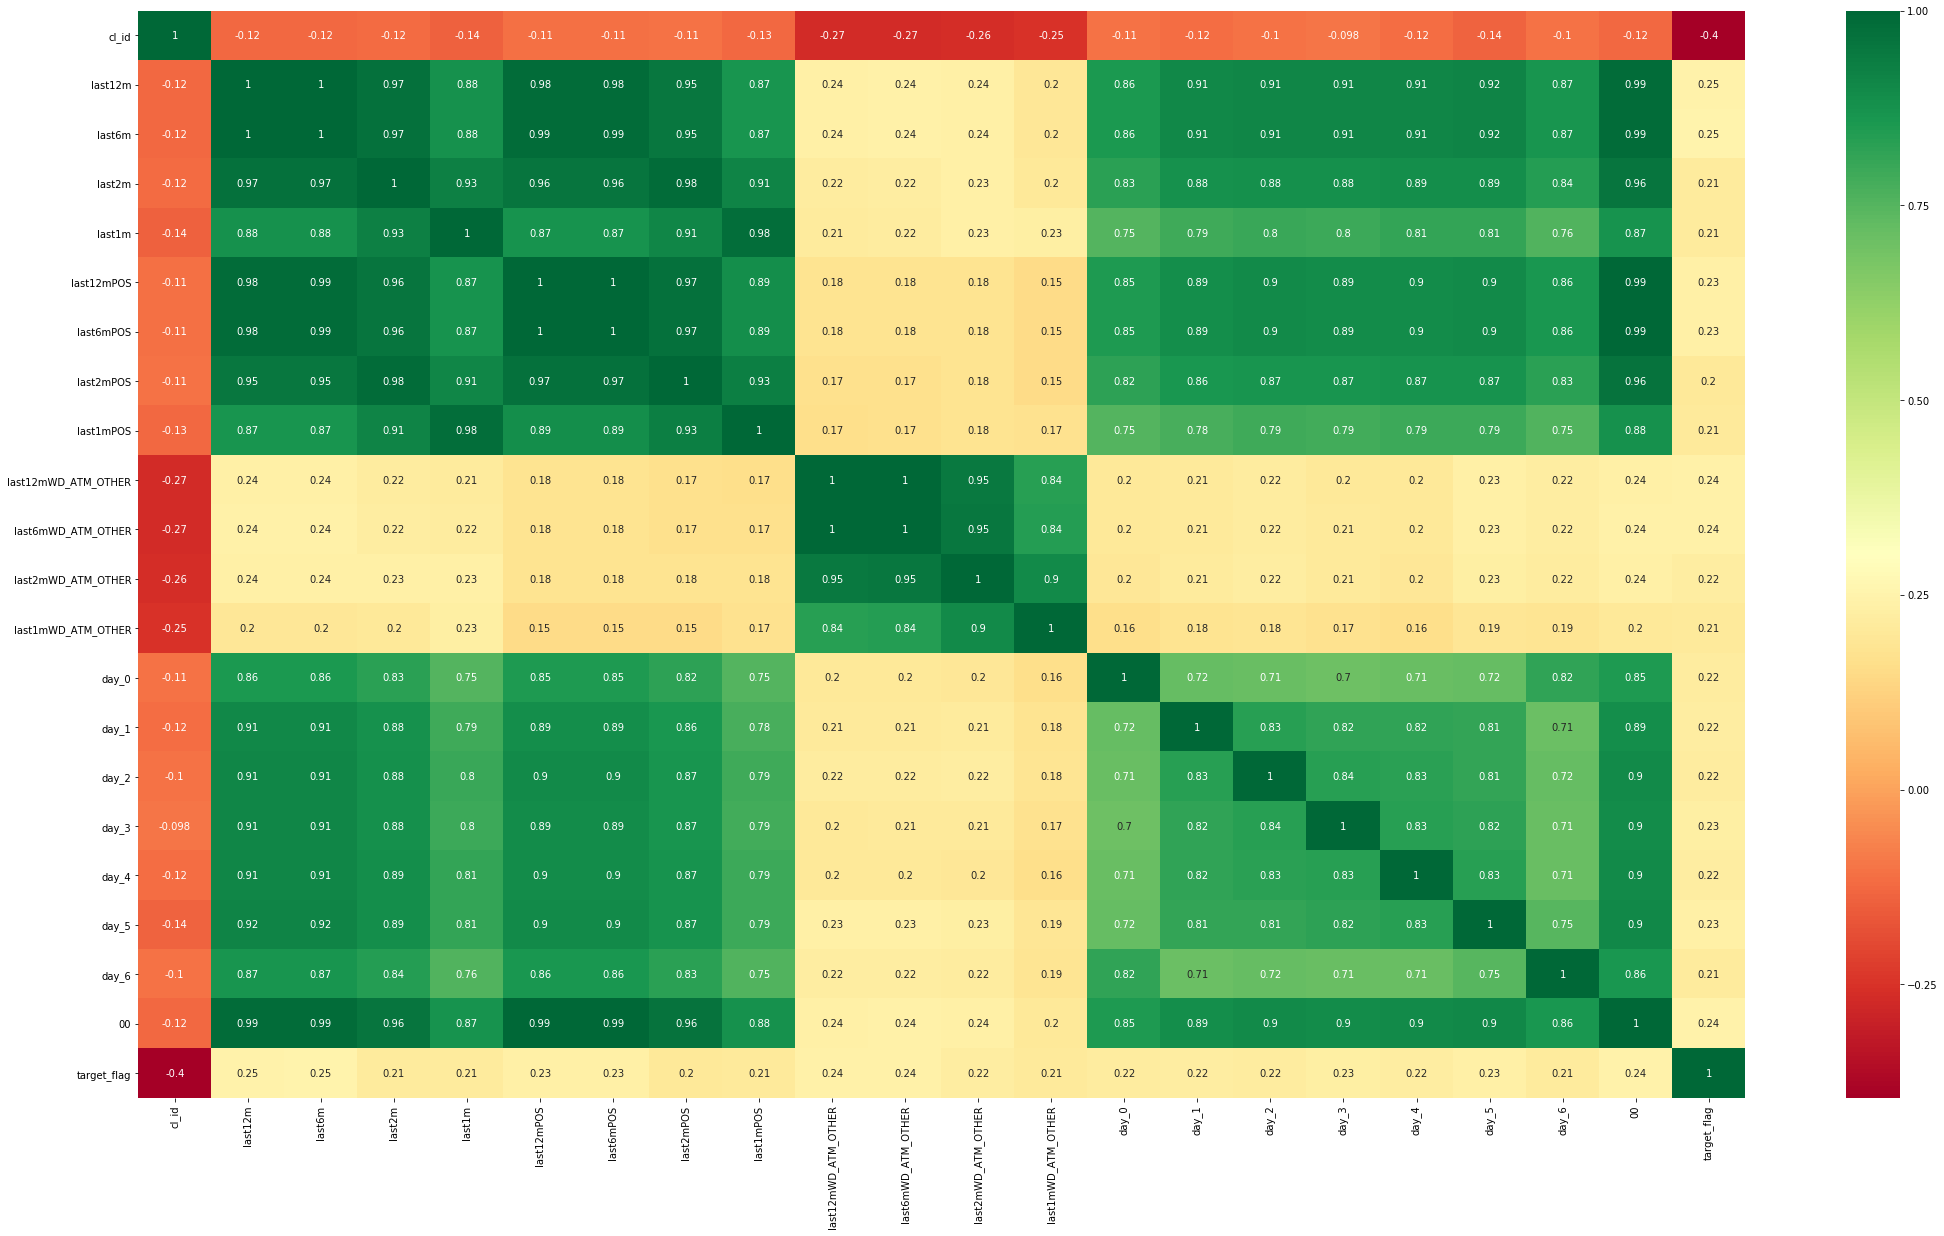

In [49]:
fig, ax = plt.subplots(figsize=(36,20))
sns.heatmap(df_train_cut.corr(),annot=True,cmap="RdYlGn");

In [50]:
%%time
sns.pairplot(data=df_train_cut,plot_kws={'alpha':0.2},hue='target_flag');

CPU times: user 57.1 s, sys: 216 ms, total: 57.3 s
Wall time: 57.4 s


In [53]:
X_test = transactions_test.drop(['target_flag','cl_id'], axis=1)
y_test = transactions_test['target_flag']
X_train = df_train_cut.drop(['target_flag','cl_id'], axis=1)
y_train = df_train_cut['target_flag']

In [54]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

In [55]:
print(X_test.shape)
X_test = X_test[cols]
print(X_test.shape)

(1000, 875)
(1000, 20)


### Линейная регрессия:

In [56]:
lm = LogisticRegression().fit(X_train,y_train)
y_train_predict = lm.predict(X_train)
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)
y_test_predict = lm.predict(X_test)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Train:  0.66
Test:  0.67


In [57]:
print(f'accuracy: {accuracy_score(y_test, y_test_predict)}')
print(f'f1: {f1_score(y_test, y_test_predict, average="macro")}')
print(f'precision: {precision_score(y_test, y_test_predict, average="macro")}')
print(f'recall: {recall_score(y_test, y_test_predict, average="macro")}')

accuracy: 0.673
f1: 0.6684615704377219
precision: 0.6680577122153208
recall: 0.6690977520089513


### Случайный лес:

In [58]:
clf = RandomForestClassifier(n_estimators=100, random_state=C_RANDOM_STATE).fit(X_train, y_train)
y_train_predict = clf.predict_proba(X_train)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  1.0


In [59]:
y_test_predict = clf.predict_proba(X_test)[:, 1]
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  0.76


In [60]:
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

In [61]:
print(f'accuracy: {accuracy_score(y_test, y_test_predict)}')
print(f'f1: {f1_score(y_test, y_test_predict, average="macro")}')
print(f'precision: {precision_score(y_test, y_test_predict, average="macro")}')
print(f'recall: {recall_score(y_test, y_test_predict, average="macro")}')

accuracy: 0.685
f1: 0.6791525553207202
precision: 0.6794165646674827
recall: 0.6789238124300682


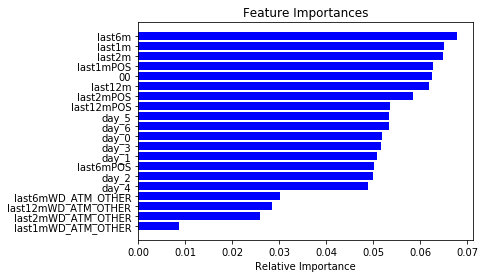

In [62]:
features = X_train.columns
importances = clf.feature_importances_[0:20]

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Случайный лес явно лидирует в данном зачете!

## Посмотрим, что мы можем улучшить с помощью понижения размерности:

In [63]:
print(f'Текущая размерность датасета: {df.shape}')

Текущая размерность датасета: (5000, 877)


In [64]:
# Возьмем для начала сжатие до 10 компонент
n=10
pca = PCA(n_components=n)
pc = pca.fit_transform(df.drop(['target_flag'], axis=1,inplace=False))
df_pc = pd.DataFrame(data = pc, columns = ['pc'+str(i) for i in range(n)])
df_with_pc = pd.concat([df_pc, df[['cl_id','target_flag']]], axis = 1)

Теперь натравим на этот датасет случайный лес (как наилучший алгоритм на тесте):

In [65]:
transactions_train = df_with_pc[~df_with_pc.cl_id.isin(cl_ids_test)].copy()
transactions_test = df_with_pc[df_with_pc.cl_id.isin(cl_ids_test)].copy()
X_test = transactions_test.drop(['target_flag','cl_id'], axis=1)
y_test = transactions_test['target_flag']
X_train = transactions_train.drop(['target_flag','cl_id'], axis=1)
y_train = transactions_train['target_flag']

In [66]:
clf = RandomForestClassifier(n_estimators=100, random_state=C_RANDOM_STATE).fit(X_train, y_train)
y_train_predict = clf.predict_proba(X_train)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)
y_test_predict = clf.predict_proba(X_test)[:, 1]
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)
print(f'accuracy: {accuracy_score(y_test, y_test_predict)}')
print(f'f1: {f1_score(y_test, y_test_predict, average="macro")}')
print(f'precision: {precision_score(y_test, y_test_predict, average="macro")}')
print(f'recall: {recall_score(y_test, y_test_predict, average="macro")}')

Train:  1.0
Test:  0.73
accuracy: 0.67
f1: 0.6635934741211635
precision: 0.6640059508482821
recall: 0.6632692503305869


Лучше не стало. Может 10 компонент - не самое оптимальное количество? Посмотрим на все возможные комбинации и результаты на тесте:

In [68]:
l_result = []
for n in range(1,df.shape[1]-1):
    pca = PCA(n_components=n, random_state=C_RANDOM_STATE)
    pc = pca.fit_transform(df.drop(['target_flag'], axis=1,inplace=False))
    df_pc = pd.DataFrame(data = pc, columns = ['pc'+str(i) for i in range(n)])
    df_with_pc = pd.concat([df_pc, df[['target_flag','cl_id']]], axis = 1)
    
    transactions_train = df_with_pc[~df_with_pc.cl_id.isin(cl_ids_test)].copy()
    transactions_test = df_with_pc[df_with_pc.cl_id.isin(cl_ids_test)].copy()
    X_test = transactions_test.drop(['target_flag','cl_id'], axis=1)
    y_test = transactions_test['target_flag']
    X_train = transactions_train.drop(['target_flag','cl_id'], axis=1)
    y_train = transactions_train['target_flag']
    
    clf = RandomForestClassifier(n_estimators=100, random_state=C_RANDOM_STATE, n_jobs=-1).fit(X_train, y_train)
    y_test_predict_proba = clf.predict_proba(X_test)[:, 1]
    y_test_predict = clf.predict(X_test)
    l_result.append((n,np.round(roc_auc_score(y_test, y_test_predict_proba), 2),accuracy_score(y_test, y_test_predict),f1_score(y_test, y_test_predict, average="macro")))

In [69]:
# отсортируем по наивысшему ROC_AUC на тесте и F-мере
l_result.sort(key=lambda x:x[1]*10+x[3],reverse=True)
l_result

[(792, 0.8, 0.724, 0.7110117103080866),
 (819, 0.8, 0.719, 0.7037336934919465),
 (164, 0.79, 0.737, 0.7294547639107057),
 (161, 0.79, 0.728, 0.7201001053740779),
 (805, 0.79, 0.73, 0.7162673392181589),
 (154, 0.79, 0.724, 0.7161790293322803),
 (197, 0.79, 0.724, 0.7157862218103181),
 (225, 0.79, 0.724, 0.71517733306915),
 (172, 0.79, 0.721, 0.7148379328918602),
 (157, 0.79, 0.722, 0.7143162498561305),
 (323, 0.79, 0.721, 0.7108901164833047),
 (771, 0.79, 0.725, 0.7103357472021066),
 (827, 0.79, 0.725, 0.7097806046905786),
 (774, 0.79, 0.723, 0.7095751094335667),
 (828, 0.79, 0.723, 0.7087763454900811),
 (797, 0.79, 0.722, 0.7083948711063373),
 (156, 0.79, 0.717, 0.7076322447541683),
 (831, 0.79, 0.722, 0.7073141971565258),
 (841, 0.79, 0.721, 0.7069447785227285),
 (725, 0.79, 0.721, 0.7063995428672452),
 (740, 0.79, 0.722, 0.7061857413419913),
 (743, 0.79, 0.721, 0.7061224489795919),
 (651, 0.79, 0.718, 0.7039295478311265),
 (728, 0.79, 0.717, 0.7038134799404278),
 (793, 0.79, 0.717, 0

In [70]:
print(f'Лучшее количество компонент: {l_result[0][0]}')

Лучшее количество компонент: 792


In [73]:
n=l_result[0][0]
pca = PCA(n_components=n, random_state=C_RANDOM_STATE)
pc = pca.fit_transform(df.drop(['target_flag'], axis=1,inplace=False))
df_pc = pd.DataFrame(data = pc, columns = ['pc'+str(i) for i in range(n)])
df_with_pc = pd.concat([df_pc, df[['target_flag','cl_id']]], axis = 1)

X_test = transactions_test.drop(['target_flag','cl_id'], axis=1)
y_test = transactions_test['target_flag']
X_train = transactions_train.drop(['target_flag','cl_id'], axis=1)
y_train = transactions_train['target_flag']

In [74]:
print(f'Найдем наилучшие гиперпараметры для случайного леса для тренировочного набора для полученного датасета из {n} компонент(ы):')

Найдем наилучшие гиперпараметры для случайного леса для тренировочного набора для полученного датасета из 792 компонент(ы):


In [ ]:
parameters = {
    'n_estimators'      : [50,100,200,300,500],
    'max_depth'         : [10, 15, 20, 25, 30],
    'min_samples_split' : [2,10,100]
}

gscv = GridSearchCV(RandomForestClassifier(random_state=C_RANDOM_STATE), parameters, cv=10, n_jobs=-1)
gscv.fit(X_train, y_train)

print(gscv.score(X_test, y_test))
print(gscv.best_params_)

In [ ]:
cv_best_params = gscv.best_params_
clf = RandomForestClassifier(n_estimators=cv_best_params['n_estimators'],max_depth=cv_best_params['max_depth'],min_samples_split=cv_best_params['min_samples_split'],
                             random_state=C_RANDOM_STATE, n_jobs=-1).fit(X_train, y_train)
# clf = RandomForestClassifier(n_estimators=100, random_state=C_RANDOM_STATE, n_jobs=-1).fit(X_train, y_train)
y_test_predict = clf.predict_proba(X_test)[:, 1]
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test ROC_AUC: ", roc_auc_test)
y_test_predict = clf.predict(X_test)
print(f'Test accuracy: {accuracy_score(y_test, y_test_predict)}')
print(f'Test f1: {f1_score(y_test, y_test_predict, average="macro")}')
print(f'Test precision: {precision_score(y_test, y_test_predict, average="macro")}')
print(f'Test recall: {recall_score(y_test, y_test_predict, average="macro")}')

features = X_train.columns
importances = clf.feature_importances_[0:20]

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

В итоге, лучше 0.82 не стало.